<a href="https://colab.research.google.com/github/TheresaZhu21/learning/blob/main/port_construction_excercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio construction excercise 2

In [ ]:
# !pip install yfinance
# !pip install pyportfolioopt

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pypfopt import CLA
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

## 1. Risk & return

### 1.1 Risk factors & financial crisis

In [ ]:
start, end = '2005-01-01', '2010-12-31'

In [ ]:
df_port = pdr.get_data_yahoo('VMBS', start=start, end=end) # Vanguard MBS Index Fund
df_port['Return'] = df_port['Adj Close'].pct_change()
df_port.head()

In [ ]:
# Convert daily returns to quarterly average returns
returns_q = df_port['Return'].resample('Q').mean().dropna()
returns_q = pd.DataFrame(returns_q)
returns_q['Min Return'] = df_port['Return'].resample('Q').min().dropna()
returns_q.head(3)

In [ ]:
# Quaterly volatility
returns_q['Volatility'] = df_port['Return'].resample('Q').std()
returns_q['90-Day Mortgage Delinquency Rate'] = [0.048, 0.045, 0.044, 0.042, 0.041, 0.040, 0.038, 0.039, 0.039]
returns_q.head(2)

In [ ]:
# Regress quarterly volatility against delinquencies
model_OLS3 = sm.OLS(returns_q['Volatility'], returns_q['90-Day Mortgage Delinquency Rate']).fit()
print(model_OLS3.summary())

In [ ]:
# Regress quarterly average returns against delinquencies
model_OLS = sm.OLS(returns_q['Return'], returns_q['90-Day Mortgage Delinquency Rate']).fit()
print(model_OLS.summary())

In [ ]:
# Regress quarterly minimum returns against delinquencies
model_OLS2 = sm.OLS(returns_q['Min Return'], returns_q['90-Day Mortgage Delinquency Rate']).fit()
print(model_OLS2.summary())

### 1.2 Modern Portfolio Theory (MPT) 

#### 1.2.1 Simple example

In [ ]:
df_port2 = pdr.get_data_yahoo(['AAPL', 'AMZN', 'GOOG', 'NFLX'], start=start, end=end)
df_port2 = df_port2['Adj Close']
df_port2.head(2)

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,GOOG,NFLX
Date,,,,
2005-01-03,0.963385,2.226,5.048826,1.702857
2005-01-04,0.973279,2.107,4.844342,1.665714


In [ ]:
# Computes the annualized average historical returns (expected return)
exp_rtn = mean_historical_return(df_port2, frequency=252)
exp_rtn

AAPL    0.474456
AMZN    0.265961
GOOG    0.198296
NFLX    0.573292
dtype: float64

In [ ]:
# Derive efficient estimates of covariance matrix
efficient_cov = CovarianceShrinkage(df_port2).ledoit_wolf() 
# CovarianceShrinkage(): improves sample covariance by shrinking extreme errors caused by sampling
# ledoit_wolf(): popular method to compute estimates of covariance matrix
efficient_cov

,AAPL,AMZN,GOOG,NFLX
AAPL,0.163077,0.083445,0.073156,0.063058
AMZN,0.083445,0.228379,0.076187,0.083230
GOOG,0.073156,0.076187,0.128224,0.041846
NFLX,0.063058,0.083230,0.041846,0.274708


In [ ]:
# Create the CLA object
cla = CLA(exp_rtn, efficient_cov)
min_variance = cla.min_volatility()
rtn, vol, weights = cla.efficient_frontier()

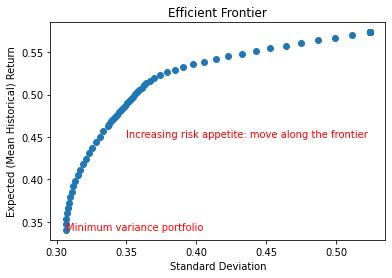

In [ ]:
# Visualize the efficient frontier
plt.scatter(vol, rtn)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected (Mean Historical) Return')
plt.title('Efficient Frontier')
plt.text(vol[-1], rtn[-1], 'Minimum variance portfolio', color='r')
plt.text(0.35, 0.45, 'Increasing risk appetite: move along the frontier', color='r')
plt.show()

#### 1.2.2 Advanced example

In [ ]:
# Create a dictionary of time periods
epochs = {'before_crisis': {'start': '2005-01-01', 'end': '2006-12-31'},
          'during_crisis': {'start': '2007-01-01', 'end': '2008-12-31'},
          'after_crisis': {'start': '2009-01-01', 'end': '2010-12-31'}}

# Compute the efficient covariance for each epoch
efficient_cov = {}
returns = {}

for x in epochs.keys():
  sub_price = df_port2.loc[epochs[x]['start']:epochs[x]['end']]
  returns[x] = mean_historical_return(sub_price, frequency=252)
  efficient_cov[x] = CovarianceShrinkage(sub_price).ledoit_wolf()

print(returns['during_crisis'])
efficient_cov['during_crisis']

AAPL    0.009224
AMZN    0.151437
GOOG   -0.189197
NFLX    0.059963
dtype: float64


,AAPL,AMZN,GOOG,NFLX
AAPL,0.244550,0.157735,0.123776,0.124143
AMZN,0.157735,0.349792,0.135435,0.124345
GOOG,0.123776,0.135435,0.187649,0.071410
NFLX,0.124143,0.124345,0.071410,0.331830


In [ ]:
efficient_portfolio_before = CLA(returns['before_crisis'], efficient_cov['before_crisis'])
(rtn_before, vol_before, weights_before) = efficient_portfolio_before.efficient_frontier()

efficient_portfolio_during = CLA(returns['during_crisis'], efficient_cov['during_crisis'])
(rtn_during, vol_during, weights_during) = efficient_portfolio_during.efficient_frontier()

efficient_portfolio_after = CLA(returns['after_crisis'], efficient_cov['after_crisis'])
(rtn_after, vol_after, weights_after) = efficient_portfolio_after.efficient_frontier()
print(f"Minimum variance:\nBefore crisis: {efficient_portfolio_before.min_volatility()}\nDuring crisis: {efficient_portfolio_during.min_volatility()}\nAfter crisis: {efficient_portfolio_after.min_volatility()}")

Minimum variance:
Before crisis: OrderedDict([('AAPL', 0.23622359508261312), ('AMZN', 0.24957523254712735), ('GOOG', 0.3319824693326734), ('NFLX', 0.18221870303758614)])
During crisis: OrderedDict([('AAPL', 0.17166716487437697), ('AMZN', 0.04451325113781687), ('GOOG', 0.5407853259322538), ('NFLX', 0.2430342580555523)])
After crisis: OrderedDict([('AAPL', 0.36012389130503736), ('AMZN', 0.05225967010630641), ('GOOG', 0.45912424952398745), ('NFLX', 0.12849218906466883)])


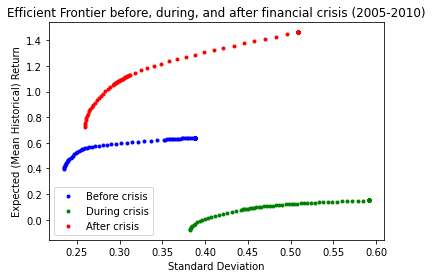

In [ ]:
# Visualize the efficient frontier
plt.scatter(vol_before, rtn_before, c='b', marker='.', label='Before crisis')
plt.scatter(vol_during, rtn_during, c='g', marker='.', label='During crisis')
plt.scatter(vol_after, rtn_after, c='r', marker='.', label='After crisis')
plt.title('Efficient Frontier before, during, and after financial crisis (2005-2010)')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected (Mean Historical) Return')
plt.legend()
plt.show()